## Library Imports

In [1]:
from time import time
notebook_start_time = time()

In [2]:
import os
import re
import pickle
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Constants and Utilities

In [3]:
SEED = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = "../input/petfinder-pawpularity-score"

sc_X = StandardScaler()
sc_y = StandardScaler()

In [4]:
def breaker(num=50, char="*") -> None:
    print("\n" + num*char + "\n")


def head(x, no_of_ele=5) -> None:
    print(x[:no_of_ele])


def get_data(path: str, name: str) -> tuple:
    df = pd.read_csv(os.path.join(path, name), engine="python")
    targets = None
    
    if name == "train.csv":
        features = df.iloc[:, 1:-1].copy().values
        targets  = df.iloc[:, -1].copy().values
    else:
        features = df.iloc[:, 1:].copy().values
    
    return features, targets


def show_graphs(L: list) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])    
    
    x_Axis = np.arange(1, len(L) + 1)
    plt.figure()
    plt.plot(x_Axis, TL, "r", label="train")
    plt.plot(x_Axis, VL, "b", label="valid")
    plt.grid()
    plt.legend()
    plt.title("MSE Loss")
    plt.show()


## Dataset Template

In [5]:
class MetaDataDS(Dataset):
    def __init__(self, X=None, y=None, mode="train"):
        self.mode = mode
        assert(re.match(r"train", self.mode, re.IGNORECASE) or re.match(r"valid", self.mode, re.IGNORECASE) or re.match(r"test", self.mode, re.IGNORECASE))

        self.X = X
        if re.match(r"train", self.mode, re.IGNORECASE) or re.match(r"valid", self.mode, re.IGNORECASE):
            self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if re.match(r"train", self.mode, re.IGNORECASE) or re.match(r"valid", self.mode, re.IGNORECASE):
            return torch.FloatTensor(self.X[idx]), torch.FloatTensor(self.y[idx])
        else:
            return torch.FloatTensor(self.X[idx])

## Build Dataloaders

In [6]:
def build_loaders(features_1: np.ndarray, 
                  targets_1: np.ndarray,
                  batch_size: int,
                  features_2=None, 
                  targets_2=None, 
                  seed=None):
    
    if features_2 is None or targets_2 is None:
        ts_data_setup = MetaDataDS(X=features_1, y=targets_1, mode="valid")
        dataloaders = DL(ts_data_setup, batch_size=batch_size, shuffle=False)
    
    else:
        tr_data_setup = MetaDataDS(X=features_1, y=targets_1, mode="train")
        va_data_setup = MetaDataDS(X=features_2, y=targets_2, mode="valid")

        dataloaders = {
            "train" : DL(tr_data_setup, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(seed)),
            "valid" : DL(va_data_setup, batch_size=batch_size, shuffle=False)
        }

    return dataloaders

## Build Model

In [7]:
def build_model(IL, HL, seed: int):
    class MetaDataModel(nn.Module):
        def __init__(self, IL=None, HL=None):
            super(MetaDataModel, self).__init__()
            self.model = nn.Sequential()

            if len(HL) == 0:
                self.model.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
                self.model.add_module("FC1", WN(nn.Linear(in_features=IL, out_features=1)))

            elif len(HL) == 1:
                self.model.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
                self.model.add_module("FC1", WN(nn.Linear(in_features=IL, out_features=HL[0])))
                self.model.add_module("AN1", nn.ReLU())
                self.model.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
                self.model.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=1)))

            elif len(HL) == 2:
                self.model.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
                self.model.add_module("FC1", WN(nn.Linear(in_features=IL, out_features=HL[0])))
                self.model.add_module("AN1", nn.ReLU())
                self.model.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
                self.model.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=HL[1])))
                self.model.add_module("AN2", nn.ReLU())
                self.model.add_module("BN3", nn.BatchNorm1d(num_features=HL[1], eps=1e-5))
                self.model.add_module("FC3", WN(nn.Linear(in_features=HL[1], out_features=1)))

            elif len(HL) == 3:
                self.model.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
                self.model.add_module("FC1", WN(nn.Linear(in_features=IL, out_features=HL[0])))
                self.model.add_module("AN1", nn.ReLU())
                self.model.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
                self.model.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=HL[1])))
                self.model.add_module("AN2", nn.ReLU())
                self.model.add_module("BN3", nn.BatchNorm1d(num_features=HL[1], eps=1e-5))
                self.model.add_module("FC3", WN(nn.Linear(in_features=HL[1], out_features=HL[2])))
                self.model.add_module("AN3", nn.ReLU())
                self.model.add_module("BN4", nn.BatchNorm1d(num_features=HL[2], eps=1e-5))
                self.model.add_module("FC4", WN(nn.Linear(in_features=HL[2], out_features=1)))

            else:
                raise ValueError("Incorrect Value supplied to 'HL' Argument")

        def get_optimizer(self, lr=1e-3, wd=0.0):
            return optim.Adam(self.parameters(), lr=lr, weight_decay=wd)

        def get_plateau_scheduler(self, optimizer=None, patience=5, eps=1e-8):
            return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps)

        def forward(self, x):
            return self.model(x)
    
    
    breaker()
    print("Building MetaData Model ...")
    print("\n {} -> {} -> {}".format(IL, HL, 1))

    torch.manual_seed(seed)
    model = MetaDataModel(IL=IL, HL=HL)
    return model

## Fit and Predict Helpers

In [8]:
def fit(model=None, optimizer=None, scheduler=None, 
        epochs=None,early_stopping_patience=None,
        dataloaders=None,
        seed=None, fold=None, batch_size=None, lr=None, wd=None, HL=None,
        verbose=False):
    
    name = "./Seed_{}_Fold_{}_Batch_{}_LR_{}_WD_{}_HL_{}_state.pt".format(seed, fold, batch_size, lr, wd, HL)
    
    breaker()
    print("Training ...")
    breaker()

    Losses = []
    bestLoss = {"train" : np.inf, "valid" : np.inf}

    model.to(DEVICE)
    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss = {"train" : np.inf, "valid" : np.inf}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass = []

            for X, y in dataloaders[phase]:
                X, y = X.to(DEVICE), y.to(DEVICE)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.MSELoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass.append(loss.item())
            epochLoss[phase] = np.mean(np.array(lossPerPass))
        Losses.append(epochLoss)

        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save({"model_state_dict": model.state_dict(),
                            "optim_state_dict": optimizer.state_dict()},
                           name)
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save({"model_state_dict": model.state_dict(),
                        "optim_state_dict": optimizer.state_dict()},
                       name)
        
        if scheduler:
            scheduler.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], time()-e_st))
    
    breaker()
    print("Best Validation Loss at Epoch {}".format(BLE))
    breaker()
    print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    breaker()
    print("Training Completed")
    breaker()

    return Losses, BLE, name

#####################################################################################################

def predict_batch(model=None, dataloader=None, mode="test", path=None):
    model.load_state_dict(torch.load(path, map_location=DEVICE)["model_state_dict"])
    model.to(DEVICE)
    model.eval()

    y_pred = torch.zeros(1, 1).to(DEVICE)
    if re.match(r"valid", mode, re.IGNORECASE):
        for X, _ in dataloader:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = model(X)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    elif re.match(r"test", mode, re.IGNORECASE):
        for X in dataloader:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = model(X)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    return y_pred[1:].detach().cpu().numpy()

## Search

In [9]:
def search():
    DEBUG = True
    
    epochs, early_stopping = 100, 10
    
    features, targets = get_data(PATH, "train.csv")
    ts_features, _ = get_data(PATH, "test.csv")
    
    if DEBUG:
        n_splits = 3
        seeds = [0]
        fold = 1
        batch_sizes = [512]
        lrs = [1e-3]
        wds = [0]
        HLs = [[4]]
        params = []
    else:
        r.seed(SEED)
        n_splits = 5
        seeds = [r.randint(0, 99) for _ in range(5)]
        fold = 1
        # batch_sizes = [64, 128, 256, 512]
        batch_sizes = [512]
        # lrs = [1e-2, 1e-3, 1e-4, 1e-5]
        lrs = [1e-3, 5e-4, 1e-4]
        wds = [0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
        HLs = [[32], [64], [128], [256], [512]]
        params = []

    
    search_optimal_start_time = time()
    for seed in seeds:
        fold = 1
        for tr_idx, va_idx in KFold(n_splits=n_splits, shuffle=True, random_state=seed).split(features):
            tr_features, va_features = features[tr_idx], features[va_idx]
            tr_targets, va_targets   = targets[tr_idx], targets[va_idx]
            tr_targets, va_targets   = tr_targets.reshape(-1, 1), va_targets.reshape(-1, 1)
            
            tr_features, tr_targets = sc_X.fit_transform(tr_features), sc_y.fit_transform(tr_targets)
            va_features, va_targets = sc_X.transform(va_features), sc_y.transform(va_targets)
            
            ts_features = sc_X.transform(ts_features)
            
            for batch_size in batch_sizes:
                dataloaders = build_loaders(tr_features, tr_targets, batch_size, va_features, va_targets, seed)
                
                for lr in lrs:
                    for wd in wds:
                        for HL in HLs:
                            breaker()
                            print("Seed: {}, Fold: {}, Batch Size: {}, LR: {}, WD: {}, HL: {}".format(seed, fold, batch_size, lr, wd, HL))
                                    
                            model = build_model(tr_features.shape[1], HL, seed=seed)
                            optimizer = model.get_optimizer(lr=lr, wd=wd)
                            
                            L, _, name = fit(model=model, optimizer=optimizer, scheduler=None, epochs=epochs, early_stopping_patience=early_stopping,
                                             dataloaders=dataloaders, seed=seed, fold=fold, batch_size=batch_size, lr=lr, wd=wd, HL=HL, verbose=True)
                            
                            y_pred = predict_batch(model=model, dataloader=dataloaders["valid"], mode="valid", path=name)
                            RMSE = np.sqrt(mean_squared_error(y_pred, va_targets))
                            print("Validation RMSE : {:.5f}".format(RMSE))
                            breaker()
                            show_graphs(L)
                            
                            param_dict = {"seed" : seed, "fold" : fold, "batch_size" : batch_size, "lr" : lr, "wd" : wd, "HL" : HL, "RMSE" : RMSE}
                            params.append(param_dict)
            fold += 1
        
    breaker()
    print("Total Time to search for optimal hyperparameters : {:.2f} minutes".format((time() - search_optimal_start_time)/60))
    breaker()
    
    return params


**************************************************

Seed: 0, Fold: 1, Batch Size: 512, LR: 0.001, WD: 0, HL: [4]

**************************************************

Building MetaData Model ...

 12 -> [4] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.29295 | Valid Loss: 1.05223 | Time: 0.41 seconds
Epoch: 2 | Train Loss: 1.22010 | Valid Loss: 1.09442 | Time: 0.34 seconds
Epoch: 3 | Train Loss: 1.16524 | Valid Loss: 1.10051 | Time: 0.33 seconds
Epoch: 4 | Train Loss: 1.12190 | Valid Loss: 1.07548 | Time: 0.34 seconds
Epoch: 5 | Train Loss: 1.09293 | Valid Loss: 1.04932 | Time: 0.33 seconds
Epoch: 6 | Train Loss: 1.06803 | Valid Loss: 1.03136 | Time: 0.33 seconds
Epoch: 7 | Train Loss: 1.05530 | Valid Loss: 1.01725 | Time: 0.34 seconds
Epoch: 8 | Train Loss: 1.04515 | Valid Loss: 1.00713 | Time: 0.33 seconds
Epoch: 9 | Train Loss: 1.03805 | Valid Loss: 1.00054 | Time: 0.33 seconds
Epo

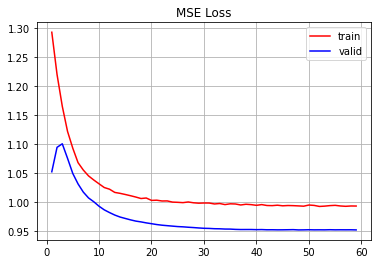


**************************************************

Seed: 0, Fold: 2, Batch Size: 512, LR: 0.001, WD: 0, HL: [4]

**************************************************

Building MetaData Model ...

 12 -> [4] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.29515 | Valid Loss: 1.11085 | Time: 0.34 seconds
Epoch: 2 | Train Loss: 1.22694 | Valid Loss: 1.14535 | Time: 0.33 seconds
Epoch: 3 | Train Loss: 1.16880 | Valid Loss: 1.14372 | Time: 0.33 seconds
Epoch: 4 | Train Loss: 1.12684 | Valid Loss: 1.12450 | Time: 0.33 seconds
Epoch: 5 | Train Loss: 1.09860 | Valid Loss: 1.10319 | Time: 0.34 seconds
Epoch: 6 | Train Loss: 1.07413 | Valid Loss: 1.08745 | Time: 0.34 seconds
Epoch: 7 | Train Loss: 1.06053 | Valid Loss: 1.07687 | Time: 0.45 seconds
Epoch: 8 | Train Loss: 1.04991 | Valid Loss: 1.06806 | Time: 0.34 seconds
Epoch: 9 | Train Loss: 1.03919 | Valid Loss: 1.06223 | Time: 0.34 seconds
Epo

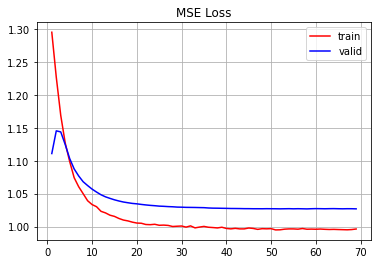


**************************************************

Seed: 0, Fold: 3, Batch Size: 512, LR: 0.001, WD: 0, HL: [4]

**************************************************

Building MetaData Model ...

 12 -> [4] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.29719 | Valid Loss: 1.09372 | Time: 0.34 seconds
Epoch: 2 | Train Loss: 1.22219 | Valid Loss: 1.13138 | Time: 0.33 seconds
Epoch: 3 | Train Loss: 1.16795 | Valid Loss: 1.12967 | Time: 0.34 seconds
Epoch: 4 | Train Loss: 1.12911 | Valid Loss: 1.11273 | Time: 0.34 seconds
Epoch: 5 | Train Loss: 1.09823 | Valid Loss: 1.09173 | Time: 0.35 seconds
Epoch: 6 | Train Loss: 1.07797 | Valid Loss: 1.07526 | Time: 0.34 seconds
Epoch: 7 | Train Loss: 1.06260 | Valid Loss: 1.06395 | Time: 0.34 seconds
Epoch: 8 | Train Loss: 1.05205 | Valid Loss: 1.05629 | Time: 0.45 seconds
Epoch: 9 | Train Loss: 1.04306 | Valid Loss: 1.04983 | Time: 0.34 seconds
Epo

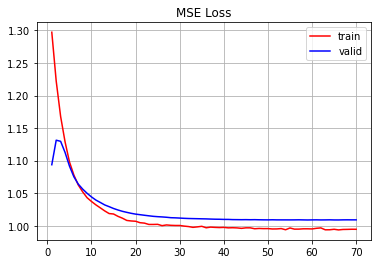


**************************************************

Total Time to search for optimal hyperparameters : 1.17 minutes

**************************************************



In [10]:
params = search()

In [11]:
for i in range(len(params)):
    print(params[i])

with open("params.pkl", "wb") as fp:
    pickle.dump(params, fp)

{'seed': 0, 'fold': 1, 'batch_size': 512, 'lr': 0.001, 'wd': 0, 'HL': [4], 'RMSE': 0.9763111014115237}
{'seed': 0, 'fold': 2, 'batch_size': 512, 'lr': 0.001, 'wd': 0, 'HL': [4], 'RMSE': 1.0164408242431435}
{'seed': 0, 'fold': 3, 'batch_size': 512, 'lr': 0.001, 'wd': 0, 'HL': [4], 'RMSE': 1.0075258732528847}


In [12]:
breaker()
print("Notebook Run Time : {:.2f} minutes".format((time()-notebook_start_time)/60))
breaker()


**************************************************

Notebook Run Time : 1.22 minutes

**************************************************

